# Histograms, histogram equalization, histogram matching

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

## Histograms and CDF (Cumulative distribution function)

Histogram is a graphical representation of frequency of our data (using bars or rectangles).

In the following lines of code, we will:
1. create random grayscale 20x20 pixels image
1. create and plot histogram
1. create and plot CDF

In [3]:
img = np.random.rand(20,20) # 20 x 20 matrix of uniformly distributed nubers from [0,1)

In [4]:
hist, bins = np.histogram(
    img.flatten(), # our image as a long vector of pixels (intensities)
    bins=50, # number of bins
    range=(0.0, 1.0), # range of pixel intensities (minimum, maximum)
) 
cdf = hist.cumsum() # calculate cdf manually as a cumulative sum

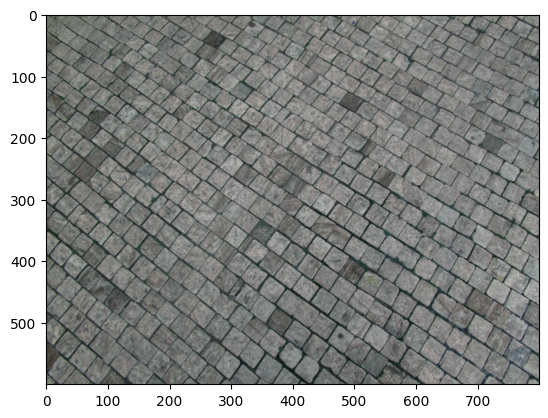

In [18]:
plt.imshow(img) # quickly show an image

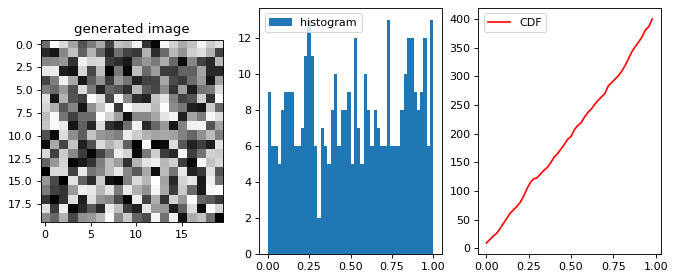

In [6]:
plt.figure(figsize=(10,4), dpi=80)

plt.subplot(131)
plt.imshow(img, cmap="gray")
plt.title(("generated image"))

plt.subplot(132)
plt.hist(img.flatten(), bins=50, label="histogram")
plt.legend()

plt.subplot(133)
plt.plot(bins[:-1], hist.cumsum(), color="r", label="CDF")
plt.legend()

## Histogram equalization

Our vague definition:
> Histogram equalization is a method which increases **contrast** of our image by manipulating its histogram.

Our algorithm:
> Histogram equalization is a function which maps original image to transformed image (pixel by pixel) by some rule (represented by look up table - LUT) we construct.


Example:
1. load an image from 'data/P.jpg'
1. convert loaded image to grayscale
1. plot histogram and CDF, CDF is normalized (Range is between 0,1)

In [19]:
img = cv.imread(os.path.join("data", "P.jpg"))
grayscaled = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

### hint - loading image from URL
If (for whatever reason) you are unable to load image from folder, you can use this snippet to load image directly from github repository:
```python
import requests # import request library
url = "https://raw.githubusercontent.com/CVUT-FS-12110/Machine-Perception-and-Image-Analysis/master/src/lectures/02_histograms/data/P.jpg"
response = requests.get(url) # get response
nparr = np.frombuffer(response.content, np.uint8) # transform content from bytestring
img = cv.imdecode(nparr, cv.IMREAD_COLOR) # transform from np vector to correct image representation
grayscaled = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
```

In [21]:
hist, bins = np.histogram(grayscaled.flatten(), bins=100, range=(0, 255))
cdf = hist.cumsum()
cdf_normalized = cdf / len(grayscaled.flatten())

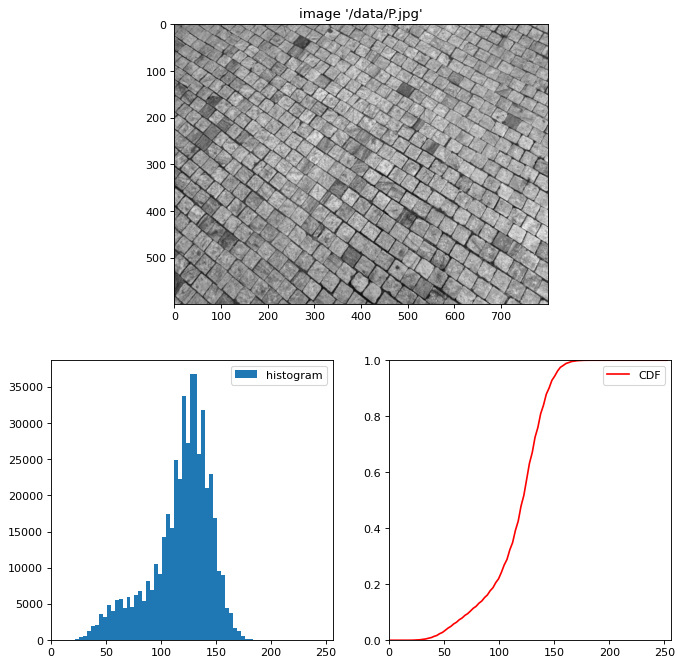

In [23]:
plt.figure(figsize=(10,10), dpi=80)

plt.subplot(211)
plt.imshow(grayscaled, cmap="gray")
plt.title(("image '/data/P.jpg'"))

plt.subplot(223)
plt.hist(grayscaled.flatten(), bins=50, label="histogram")
plt.xlim((0,256))
plt.legend()

plt.subplot(224)
plt.plot(bins[:-1], cdf_normalized, color="r", label="CDF")
plt.xlim((0,256))
plt.ylim((0,1))
plt.legend()

### Increase image contrast using look up table

We will show magic function from `opencv`, you will do something similar (histogram homework) by creating your own LUT algorithm.

In [24]:
equ = cv.equalizeHist(grayscaled) # equalize (increase contrast) of `grayscaled`
hist_equ, bins_equ = np.histogram(equ, bins=100)
cdf_equ = hist_equ.cumsum()
cdf_normalized_equ = cdf_equ / len(equ.flatten())

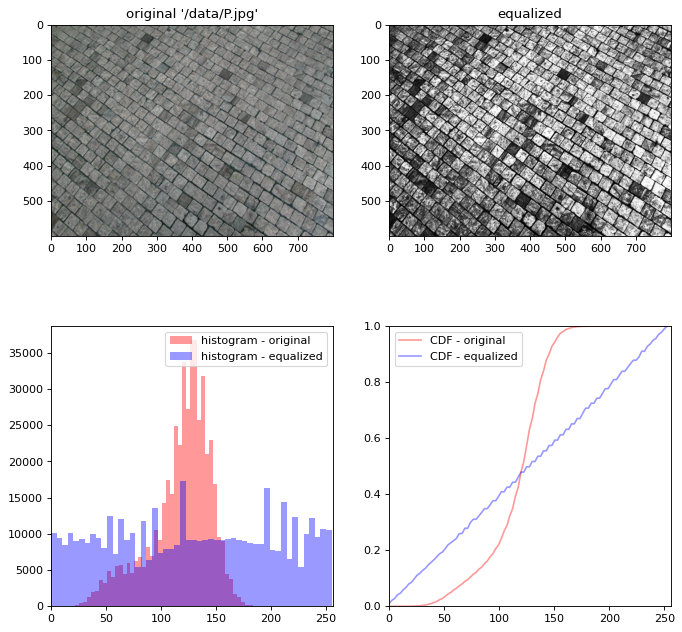

In [25]:
plt.figure(figsize=(10,10), dpi=80)

plt.subplot(221)
plt.imshow(img, cmap="gray")
plt.title(("original '/data/P.jpg'"))

plt.subplot(222)
plt.imshow(equ, cmap="gray")
plt.title(("equalized"))

plt.subplot(223)
plt.hist(grayscaled.flatten(), bins=50, alpha=0.4, color="r", label="histogram - original")
plt.hist(equ.flatten(), bins=50, alpha=0.4, color="b", label="histogram - equalized")
plt.xlim((0,256))
plt.legend()

plt.subplot(224)
plt.plot(bins[:-1], cdf_normalized, alpha=0.4, color="r", label="CDF - original")
plt.plot(bins_equ[:-1], cdf_normalized_equ, alpha=0.4, color="b", label="CDF - equalized")
plt.xlim((0,256))
plt.ylim((0,1))
plt.legend()

### Restricted histogram equalisation

If we would try naive LUT algorithm (your homework) on the following image, result should look something like this:

![example2](data/hw2_example.svg)

Our naive LUT algorithm crates so called *aratefacts*. Your second part of homework will be to create and implement algorithm which will adress this issue.

In [26]:
img = cv.imread(os.path.join("data", "L.jpg"))
grayscaled = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [28]:
hist, bins = np.histogram(grayscaled.flatten(), bins=100, range=(0, 255))
cdf = hist.cumsum()
cdf_normalized = cdf / len(grayscaled.flatten())

In [29]:
equ = cv.equalizeHist(grayscaled)
hist_equ, bins_equ = np.histogram(equ, bins=BINS)
cdf_equ = hist_equ.cumsum()
cdf_normalized_equ = cdf_equ / len(equ.flatten())

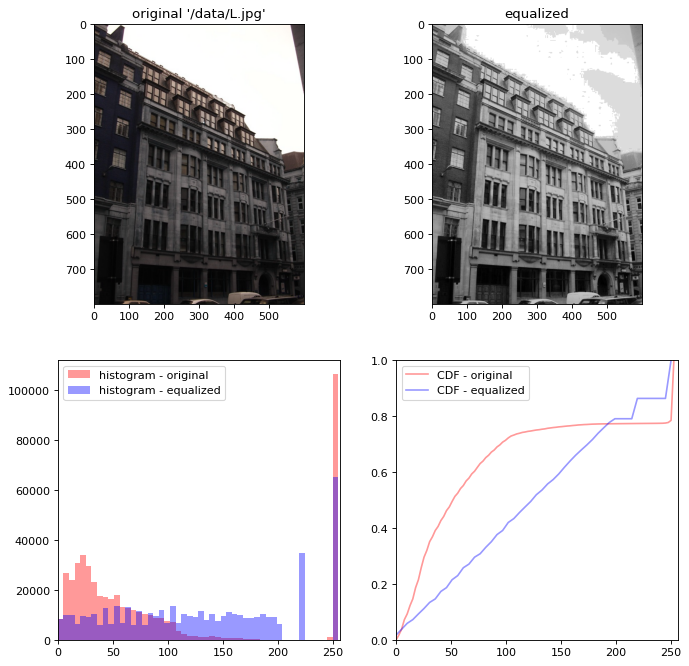

In [30]:
plt.figure(figsize=(10,10), dpi=80)

plt.subplot(221)
plt.imshow(img, cmap="gray")
plt.title(("original '/data/L.jpg'"))

plt.subplot(222)
plt.imshow(equ, cmap="gray")
plt.title(("equalized"))

plt.subplot(223)
plt.hist(grayscaled.flatten(), bins=50, alpha=0.4, color="r", label="histogram - original")
plt.hist(equ.flatten(), bins=50, alpha=0.4, color="b", label="histogram - equalized")
plt.xlim((0,256))
plt.legend()

plt.subplot(224)
plt.plot(bins[:-1], cdf_normalized, alpha=0.4, color="r", label="CDF - original")
plt.plot(bins_equ[:-1], cdf_normalized_equ, alpha=0.4, color="b", label="CDF - equalized")
plt.xlim((0,256))
plt.ylim((0,1))
plt.legend()

##  Histogram matching

Last topic will be about **histogram matching**. Such an algorithm transforms original image so that the transformed image histogram matches some reference.

Depiction of histogram matching algorithm, taken [source](https://commons.wikimedia.org/wiki/File:Histmatching.svg), author `Llorenzi`:
![](data/histogram_matching.svg)



In [64]:
def create_lut(source_cdf, reference_cdf):
    """ Function creates LUT based on provided source and reference CDF 
    Note: only works for Domain 0, 255
    """
    assert len(source_cdf) == len(reference_cdf), "CDFs have different lengths"
    n = len(source_cdf) # length of LUT
    lut = np.zeros(shape=(n,)) # prepare empty vector for LUT
    for i in range(n): # i is index of source image
        for j in range(n): # j is value of transformed image
            if reference_cdf[j] >= source_cdf[i]:
                # this is my lut value for index `i`
                lut[i] = j
                break
    return lut


In [65]:
# read images
image = cv.imread(os.path.join("data", "CM1.jpg"))
img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
reference = cv.imread(os.path.join("data", "CM2.jpg"))
ref = cv.cvtColor(reference, cv.COLOR_BGR2GRAY)

In [66]:
hist, bins = np.histogram(img.flatten(), bins=256)
cdf = hist.cumsum()
cdf_normalized = cdf / len(img.flatten())
hist_r, bins_r = np.histogram(ref.flatten(), bins=256)
cdf_r = hist_r.cumsum()
cdf_normalized_r = cdf_r / len(ref.flatten())

Text(0.5, 1.0, 'reference')

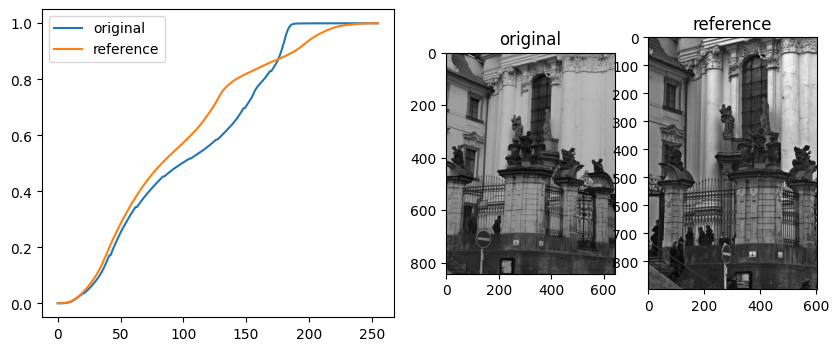

In [67]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(cdf_normalized, label="original")
plt.plot(cdf_normalized_r, label="reference")
plt.legend()
plt.subplot(143)
plt.imshow(img, cmap="gray")
plt.title("original")
plt.subplot(144)
plt.imshow(ref, cmap="gray")
plt.title("reference")

In [69]:
lut = create_lut(cdf_normalized, cdf_normalized_r) # create lut

In [72]:
# transform an image
transformed = cv.LUT(img, lut)
hist_t, bins_t = np.histogram(transformed.flatten(), bins=256)
cdf_t = hist_t.cumsum()
cdf_normalized_t = cdf_t / len(transformed.flatten())

Text(0.5, 1.0, 'reference')

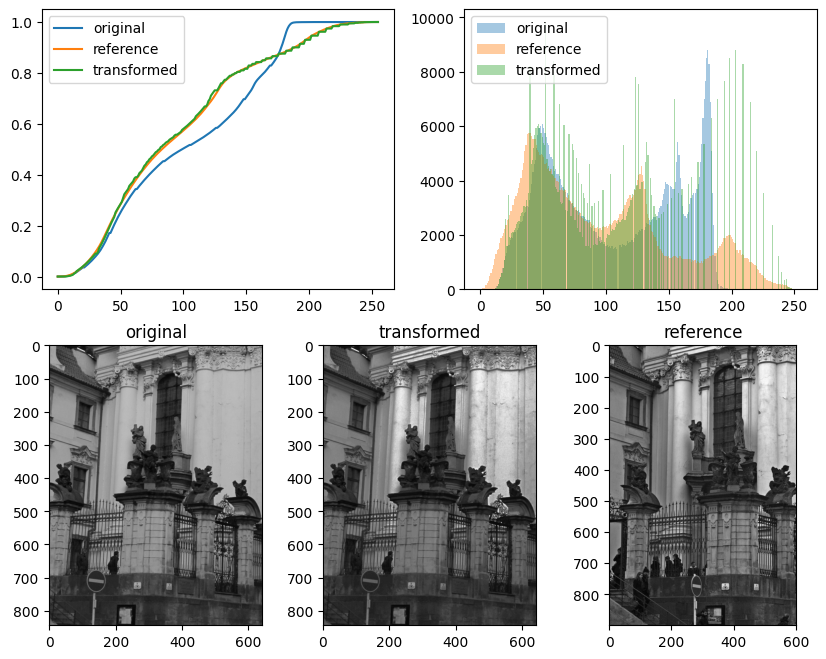

In [75]:
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.plot(cdf_normalized, label="original")
plt.plot(cdf_normalized_r, label="reference")
plt.plot(cdf_normalized_t, label="transformed")
plt.legend()
plt.subplot(222)
plt.hist(img.flatten(), alpha=0.4, bins=256, label="original")
plt.hist(ref.flatten(), alpha=0.4, bins=256, label="reference")
plt.hist(transformed.flatten(), alpha=0.4, bins=256, label="transformed")
plt.legend()

plt.subplot(234)
plt.imshow(img, cmap="gray")
plt.title("original")
plt.subplot(235)
plt.imshow(transformed, cmap="gray")
plt.title("transformed")
plt.subplot(236)
plt.imshow(ref, cmap="gray")
plt.title("reference")